In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
board = np.ones([3,4], dtype=np.uint8) * 255
red_val, red_color = 1, [255,0,0]
black_val, black_color = 0, [0,0,0]
blank_val, blank_color = 255, [255,255,255]
val2color = {red_val:red_color,
             black_val:black_color,
             blank_val:blank_color}
tag2val = {'R':red_val, 'B':black_val}
tag2opponent = {'R':'B', 'B':'R'}

In [3]:
def show_weight(weight):
    plt.imshow(weight)
    for (j,i),label in np.ndenumerate(weight):
        text = ''
        plt.text(i,j,f"{label}",ha='center',va='center', fontsize=20)
    plt.axis('off');
    plt.colorbar()
    plt.savefig('extra/simple_weight.png')
    
def bypass(row):
    return np.array(list(map(convert, row)))
    
def convert(val):
    return val2color[val]

def show_board(board):
    view_board = np.array(list(map(bypass,board)))
       
    plt.imshow(view_board)
    for (j,i),label in np.ndenumerate(board):
        text = ''
        if label == black_val: text = 'Black'
        if label == red_val: text = 'Red'
        plt.text(i,j,text,ha='center',va='center', fontsize=15, color='white')
    plt.axis('off');

def do_action(idx, tag, board, tree=None, verbose=True):
    col = board[:, idx]
    pos_position = np.where(col==255)[0]
    if len(pos_position) == 0:
        if verbose: print("Impossible")
        return board, -1, None
    idy = pos_position[-1]
    board[idy, idx] = tag2val[tag]
    if tree is None:
        return board, 0, None
    else:
        return board, 0, tree[idx]
    
def check_win(sol_board, verbose=True):
    arr_sums = []
    for idy in range(3):
        for idx in range(2):
            arr_sums.append(sol_board[idy, idx:idx+3].sum())

    for idx in range(4):
        arr_sums.append(sol_board[:, idx].sum())

    for off in range(2):
        arr_sums.append(sol_board.diagonal(off).sum())

    for off in range(2):
        arr_sums.append(np.flipud(sol_board).diagonal(off).sum())

    for elem in arr_sums:
        if elem == black_val*3:
            if verbose:print("Black Wins!")
            return 'B'
        elif elem == red_val*3:
            if verbose:print("Red Wins!")
            return 'R'
    if len(np.where(sol_board==255)[0])==0:
        if verbose:print("Tie!")
        return 'T'
    return 'N'

def makeGaussWeight(size=(3,4), fwhm = 3, center=None):

    x = np.arange(0, size[1], 1, float)
    y = np.arange(0, size[0], 1, float)[:, None]
    
    x0 = size[1] // 2
    y0 = size[0] // 2
    exp1 = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    exp2 = np.exp(-4*np.log(2) * ((x-x0+1)**2 + (y-y0)**2) / fwhm**2)

    return exp1+exp2

def makeWeight(size=(3,4), low=1, middle=2, high=4):
    weight = np.zeros(size)
    for j in range(size[0]):
        for i in range(size[1]):

            if (j == 0 or j==size[0]-1) and (i == 0 or i == size[1]-1):
                val = low
            elif j==0 or j==size[0]-1 or i==0 or i==size[1]-1:
                val = middle
            else:
                val = high
            weight[j, i] = val
    return weight
simpleW = makeWeight()

def Heuristics2(board, tag, win_num=30):
    # Based on Research on Different Heuristics for Minimax Algorithm Insight from Connect-4 Game
    # val, can_continue
    op = tag2opponent[tag]
    board_status = check_win(board, False)
    if board_status == tag: return win_num, False 
    if board_status == op:  return -win_num, False
    if board_status == 'T': return 0, False
    
    val, op_val = tag2val[tag], tag2val[op] 
    wcurr = simpleW[(board == val)].sum()
    wopp  = simpleW[(board == op_val)].sum()
    return wcurr - wopp, True

def check_action(idx, board):
    col = board[:, idx]
    pos_position = np.where(col==255)[0]
    return len(pos_position) != 0

def step(board, tag):
    row = {}
    for idx in range(board.shape[1]):
       
        new_board, code, _ = do_action(idx, tag, board.copy())
        val, can_run = Heuristics2(new_board, tag)
        row[idx] = {'board': new_board,
                    'val': val,
                    'can_run': can_run}
    return row
   
def isNum(val):
    return type(val) == int

In [4]:
def get_reward(code, start_tag):
    if code == 'T': reward = 0
    if code == start_tag: reward = 1
    if code == tag2opponent[start_tag]: reward = -1
    return reward

def create(board, h=0, start_tag='R', save_board=False):
    tag  = start_tag if (h%2)==0 else tag2opponent[start_tag]
    code = check_win(board, verbose=False)
    if code == 'T' or code == 'B' or code == 'R': #END GAME
        reward = get_reward(code, start_tag)
        info = {'reward':reward, 'h':h}
        if save_board:
            info['board'] = board
        return info
    else:
        row = {}
        for idx in range(board.shape[1]): # For every place
            new_board, code, _ = do_action(idx, tag, board.copy(), verbose=False)
            if code == -1: continue# Invalid action
            row[idx] = create(new_board, h+1, start_tag, save_board)
            if save_board:
                row[idx]['board'] = board
        rewards_list = list(map(lambda x: x['reward'], row.values()))
        
        #reward = np.sum(rewards_list)
        reward = max(rewards_list) if tag==start_tag else min(rewards_list)
        
        row['reward'] = reward
        row['h'] = h
    return row

In [5]:
%%time
board = np.ones([3,4], dtype=np.uint8) * 255
tree_original = create(board)
tree = tree_original.copy()

CPU times: user 16 s, sys: 40.3 ms, total: 16 s
Wall time: 16 s


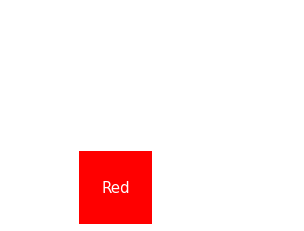

In [6]:
tree = tree_original.copy()
board = np.ones([3,4], dtype=np.uint8) * 255
board, code, tree = do_action(1, 'R',board, tree=tree, verbose=False)
show_board(board)

In [7]:
def get_childs_reward(branch):
    for key in (branch.keys()):
        if type(key) is int:
            print("P:", key, "R:",branch[key]['reward'])

In [8]:
def get_action(tree, is_max=False, verbose=True):
    target = [-1, 1][int(is_max)]
    ret_p = -1
    possible_actions = list(filter(isNum,(tree.keys())))
    for p in possible_actions:
        r = tree[p]['reward']
        if verbose:print(p, r)
        if r == target: return p
        if r == 0: ret_p = p
    if ret_p != target: return ret_p
    return possible_actions[0]

def do_min_action(tag, board, tree=None, verbose=True):
    code = check_win(board, verbose=verbose)
    if code != 'N': return board, code, tree
    idx = get_action(tree, is_max=False)
    return do_action(idx, tag, board, tree=tree, verbose=verbose)


In [33]:
tree = tree_original.copy()
board = np.ones([3,4], dtype=np.uint8) * 255

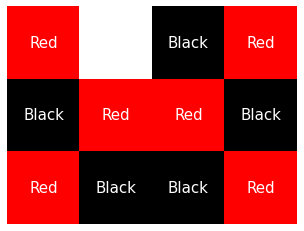

In [44]:
board, code, tree = do_action(1, 'R',board, verbose=False, tree=tree)
show_board(board)


1 0


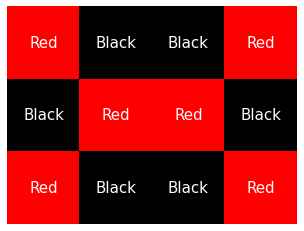

In [45]:
board, code, tree = do_min_action('B', board, tree)
show_board(board)